## Fashion MNIST

In [24]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.random.manual_seed(531)

fashion_train = FashionMNIST("datasets", download=True, transform=ToTensor())
fashion_val = FashionMNIST("datasets", train=False, transform=ToTensor())
print(fashion_train.data.shape)

torch.Size([60000, 28, 28])


In [0]:
train_loader = DataLoader(fashion_train, 32, shuffle=True)
val_loader = DataLoader(fashion_val, 32)

In [26]:
x, y = next(iter(train_loader))
x.min(), x.max()

(tensor(0.), tensor(1.))

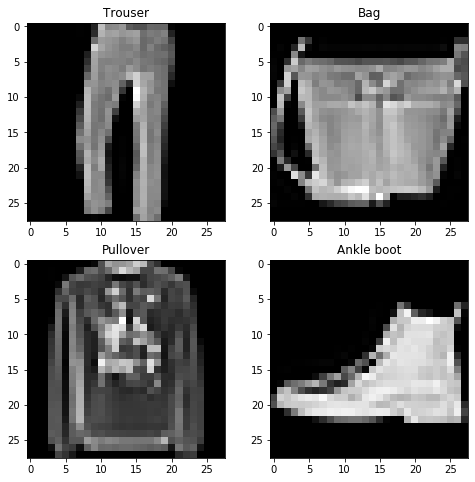

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, axis in enumerate(axes.ravel()):
    img = x[i, 0, ...].numpy()
    label = fashion_train.classes[y[i]]
    axis.imshow(img, cmap="gray")
    axis.set_title(label)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

model = resnet50(pretrained=False, num_classes=10).to("cuda")
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1)

In [0]:
# metric definitions
from IPython.display import clear_output
import numpy as np
import sklearn.metrics

def accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x.to("cuda").expand(-1, 3, -1, -1))
            correct += (pred.argmax(dim=1) == y.to("cuda")).sum()
            total += y.shape[0]
    return correct.item() / total

def confusion_matrix(model, dataloader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x.to("cuda").expand(-1, 3, -1, -1))
            preds.append(pred.argmax(dim=1).to("cpu").numpy())
            trues.append(y.numpy())
    return sklearn.metrics.confusion_matrix(np.concatenate(preds), np.concatenate(trues))

def plot_metrics(metrics):
    clear_output()
    plt.figure(figsize=(6, 5))
    for name, (xs, ys) in metrics.items():
        plt.plot(xs, ys, label=name)
    plt.legend()
    plt.show()

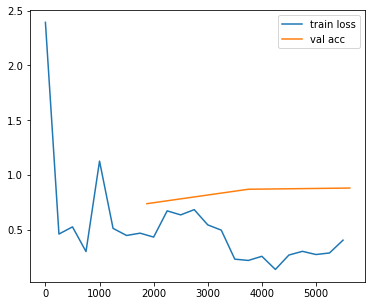

In [30]:
# train
epochs = 3
train_loss = []
val_accuracy = []
batch_no_train = []
batch_no_val = []
batch_no = 0
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        
        pred = model(x.to("cuda").expand(-1, 3, -1, -1))
        loss = F.cross_entropy(pred, y.to("cuda"))
        loss.backward()
        
        optimizer.step()
        
        if batch_no % 250 == 0:
            train_loss.append(loss)
            batch_no_train.append(batch_no)
            plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
        batch_no += 1
            
    val_accuracy.append(accuracy(model, val_loader))
    batch_no_val.append(batch_no)
    plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
    lr_scheduler.step()

In [31]:
val_accuracy

[0.7369, 0.8686, 0.8796]

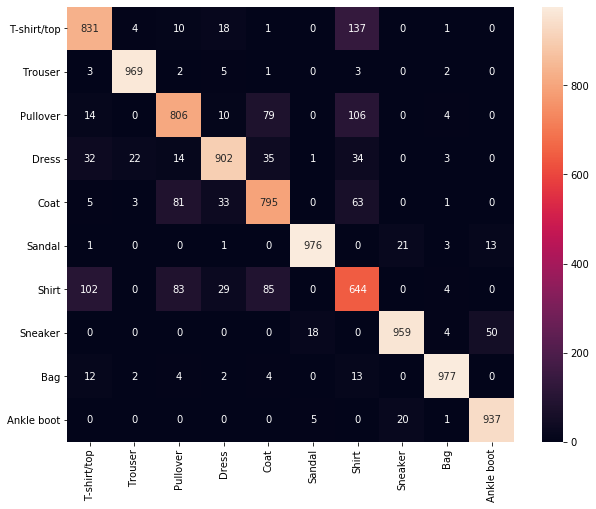

In [52]:
import seaborn as sns

cm = confusion_matrix(model, val_loader)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, xticklabels=fashion_train.classes, yticklabels=fashion_train.classes, fmt="g")

## Imagewoof

In [8]:
%%bash
curl https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz -o imagewoof2-160.tgz
tar -xf imagewoof2-160.tgz -C datasets/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88.2M  100 88.2M    0     0  10.0M      0  0:00:08  0:00:08 --:--:-- 13.9M


In [9]:
%ls datasets/

FashionMNIST/  imagewoof2-160/


In [53]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

def prepare_imagewoof(augment=False):
    tfs = [transforms.Resize((128, 128))]
    if augment:
        tfs.extend([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.25, 0.3, 0.2, 0.),
            transforms.RandomRotation(30)])
    tfs.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
    ])
    return transforms.Compose(tfs)

imagewoof_train = ImageFolder("datasets/imagewoof2-160/train", transform=prepare_imagewoof(True))
imagewoof_val = ImageFolder("datasets/imagewoof2-160/val", transform=prepare_imagewoof(False))

len(imagewoof_train)

9025

In [0]:
imagewoof_classes_human_readable = {
    "n02086240": "Shih Tzu",
    "n02087394": "Rhodesian ridgeback",
    "n02088364": "Beagle",
    "n02089973": "English foxhound",
    "n02093754": "Border terrier",
    "n02096294": "Australian terrier",
    "n02099601": "Golden retriever",
    "n02105641": "Old English sheepdog",
    "n02111889": "Samoyed",
    "n02115641": "dingo"
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


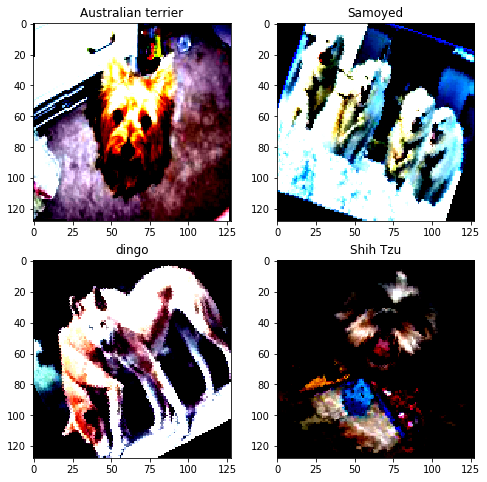

In [55]:
torch.random.manual_seed(693)
train_loader = DataLoader(imagewoof_train, 16, True, num_workers=4, drop_last=True)
val_loader = DataLoader(imagewoof_val, 16, num_workers=4)

x, y = next(iter(train_loader))

fig, axes = plt.subplots(2, 2, figsize=(8,8))
for i, axis in enumerate(axes.ravel()):
    img = x[i,  ...].numpy().transpose(1, 2, 0)
    label = imagewoof_classes_human_readable[imagewoof_train.classes[y[i]]]
    axis.imshow(img, cmap="gray")
    axis.set_title(label)

In [0]:
model = resnet50(num_classes=10).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), 8e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=5)

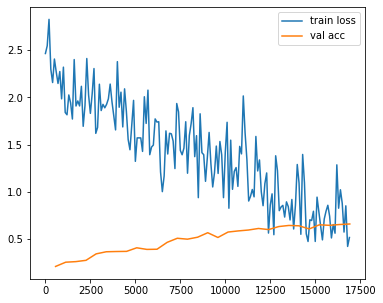

In [57]:
epochs = 30
train_loss = []
val_accuracy = []
batch_no_train = []
batch_no_val = []
batch_no = 0
for epoch in range(epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        
        pred = model(x.to("cuda"))
        loss = F.cross_entropy(pred, y.to("cuda"))
        loss.backward()
        
        optimizer.step()
        
        if batch_no % 100 == 0:
            train_loss.append(loss)
            batch_no_train.append(batch_no)
            plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
        batch_no += 1
            
    val_accuracy.append(accuracy(model, val_loader))
    batch_no_val.append(batch_no)
    plot_metrics({"train loss": (batch_no_train, train_loss), 
                  "val acc": (batch_no_val, val_accuracy)})
    lr_scheduler.step(val_accuracy[-1])

In [58]:
val_accuracy[-10:]

[0.6098243827946043,
 0.5981165691015525,
 0.6301857979129549,
 0.6418936116060067,
 0.6380758462713159,
 0.6049885467039959,
 0.64876558920845,
 0.6431662000509035,
 0.6518198014762026,
 0.6574191906337491]

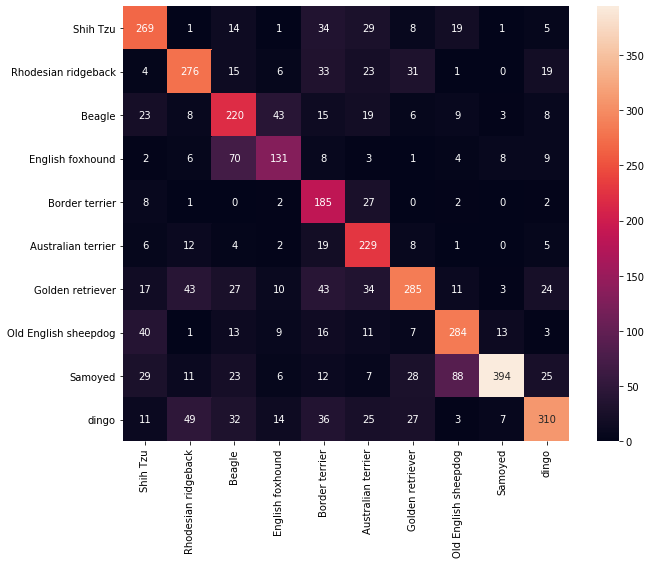

In [61]:
cm = confusion_matrix(model, val_loader)
plt.figure(figsize=(10,8))
classes = [imagewoof_classes_human_readable[c] for c in imagewoof_train.classes]
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt="g")

## Multitask model

In [0]:
backbone = resnet50(pretrained=False)
backbone.fc = nn.Sequential()  # Rip off classification layer

fashion_classifier_head = nn.Linear(2048, 10)
woof_classifier_head = nn.Linear(2048, 10)

fashion_classifier = nn.Sequential(backbone, fashion_classifier_head).to("cuda")
woof_classifier = nn.Sequential(backbone, woof_classifier_head).to("cuda")

Imagewoof dataset is 7 times smaller than Fashion MNIST (9k vs 60k). To address this imbalance problem, one of the following options can be considered:

1. Feed batches evenly. Imagewoof augmentation can help with its small size.
2. Feed proportional batches. This way Fashion MNIST dataset will give more accurate gradients than Imagewoof.
3. Decrease lr for Fashion MNIST. This can force the network to converge to Imagewoof optimum rather than mutual one.
4. Learn epochs separately and alternating with decreasing lr.

I like the first take, let's try it out. The epochs will be counted by Imagewoof dataset since it's smaller and harder to learn.

In [0]:
torch.random.manual_seed(172)

woof_train_loader = DataLoader(imagewoof_train, 16, True, num_workers=4)
woof_val_loader = DataLoader(imagewoof_val, 16, num_workers=4)
fashion_train_loader = DataLoader(fashion_train, 16, True, num_workers=2)
fashion_val_loader = DataLoader(fashion_val, 16, num_workers=2)

In [0]:
woof_optimizer = torch.optim.Adam(woof_classifier.parameters(), 0.001)
fashion_optimizer = torch.optim.Adam(fashion_classifier.parameters(), 0.0005)

# woof_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(woof_optimizer, patience=5)
# fashion_lr_scheduler = torch.optim.lr_scheduler.StepLR(fashion_optimizer, 10, 0.5)

In [0]:
import random
from collections import defaultdict
from itertools import cycle
random.seed(50)


def step(model, train_loader, optimizer):
    model.train()
    optimizer.zero_grad()
    x, y = next(train_loader)
    pred = model(x.to("cuda").expand(-1, 3, -1, -1))
    loss = F.cross_entropy(pred, y.to("cuda"))
    loss.backward()
    optimizer.step()
    return loss.item()


def plot_combined_metrics(metrics):
    plot_metrics({"woof_train_loss": (metrics["woof_train_x"], metrics["woof_train_loss"]),
                  "woof_val_acc": (metrics["woof_val_x"], metrics["woof_val_acc"]),
                  "fashion_train_loss": (metrics["fashion_train_x"], metrics["fashion_train_loss"]),
                  "fashion_val_acc": (metrics["fashion_val_x"], metrics["fashion_val_acc"])})


epochs = 50

metrics = defaultdict(list)
batch_no = 0
fashion_train_iter = cycle(fashion_train_loader)  # Never stops
for epoch in range(epochs):
    woof_train_iter = iter(woof_train_loader)  # Renewed every epoch
    while(True):
        take_woof = random.randrange(2)
        try:
            if take_woof == 1:
                loss = step(woof_classifier, woof_train_iter, woof_optimizer)
                if batch_no % 50 == 0:
                    metrics["woof_train_x"].append(batch_no)
                    metrics["woof_train_loss"].append(loss)
                    plot_combined_metrics(metrics)
            else:
                loss = step(fashion_classifier, fashion_train_iter, fashion_optimizer)
                if batch_no % 50 == 0:
                    metrics["fashion_train_x"].append(batch_no)
                    metrics["fashion_train_loss"].append(loss)
                    plot_combined_metrics(metrics)
            batch_no += 1
        except StopIteration:
            metrics["woof_val_x"].append(batch_no)
            metrics["woof_val_acc"].append(accuracy(woof_classifier, woof_val_loader))
            metrics["fashion_val_x"].append(batch_no)
            metrics["fashion_val_acc"].append(accuracy(fashion_classifier, fashion_val_loader))
            plot_combined_metrics(metrics)
            epoch += 1
            break

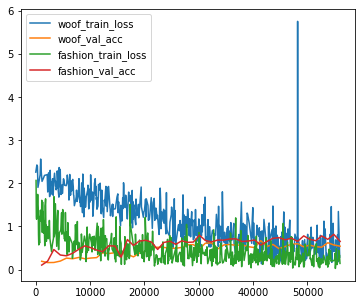

In [70]:
plot_combined_metrics(metrics)

In [71]:
print(metrics["woof_val_acc"][-10:])
print(metrics["fashion_val_acc"][-10:])

[0.5352506999236447, 0.5874268261644184, 0.5988801221684907, 0.528124204632222, 0.5670654110460677, 0.5306693815220158, 0.5197251208959023, 0.6228047849325528, 0.5713922117587172, 0.5418681598371087]
[0.6906, 0.7276, 0.6548, 0.7816, 0.7024, 0.6688, 0.7811, 0.7009, 0.8167, 0.6538]


Multitask learning takes **much longer** to train in this scenario and achieves lover scores. Perhaps, lr schedulers can help.

Now for some fun, let's see which dogs look like T-shirts.

In [76]:
y_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

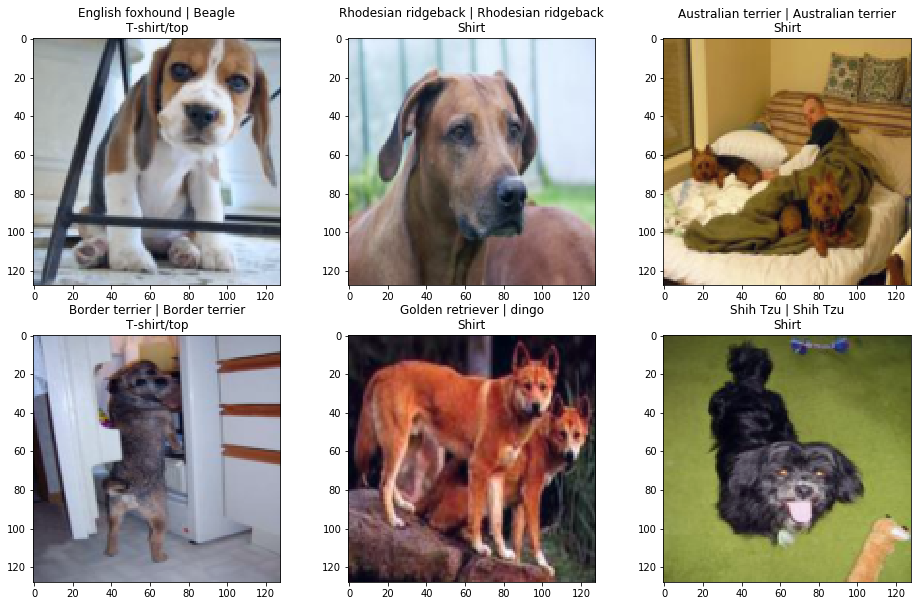

In [96]:
torch.random.manual_seed(432)
woof_loader = DataLoader(imagewoof_val, 6, True)
x_batch, y_batch = next(iter(woof_loader))

model.eval()
embedding = backbone(x_batch.to("cuda"))
woof_pred = woof_classifier_head(embedding)
fashion_pred = fashion_classifier_head(embedding)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for x, y, wpred, fpred, ax in zip(x_batch, y_batch, woof_pred, fashion_pred, axes.ravel()):
    x -= x.min()
    x /= x.max()
    ax.imshow(x.numpy().transpose(1, 2, 0))

    woof_class_true = imagewoof_val.classes[y.item()]
    woof_class_true = imagewoof_classes_human_readable[woof_class_true]
    woof_class_pred = imagewoof_val.classes[wpred.argmax().item()]
    woof_class_pred = imagewoof_classes_human_readable[woof_class_pred]
    fashion_class = fashion_train.classes[fpred.argmax().item()]

    ax.set_title(woof_class_pred + " | " + woof_class_true + "\n" +
                 fashion_class)

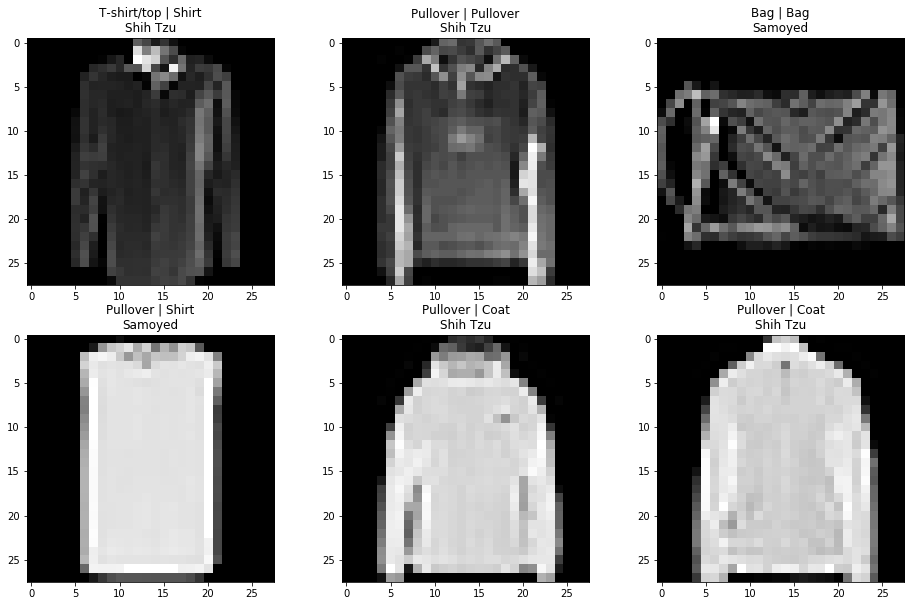

In [101]:
torch.random.manual_seed(81)
fashion_loader = DataLoader(fashion_val, 6, True)
x_batch, y_batch = next(iter(fashion_loader))

embedding = backbone(x_batch.to("cuda").expand(-1, 3, -1, -1))
woof_pred = woof_classifier_head(embedding)
fashion_pred = fashion_classifier_head(embedding)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for x, y, wpred, fpred, ax in zip(x_batch, y_batch, woof_pred, fashion_pred, axes.ravel()):
    ax.imshow(x.numpy()[0], cmap="gray")

    fashion_class_true = fashion_val.classes[y.item()]
    fashion_class_pred = fashion_val.classes[fpred.argmax().item()]
    woof_class = imagewoof_train.classes[wpred.argmax().item()]
    woof_class = imagewoof_classes_human_readable[woof_class]

    ax.set_title(fashion_class_pred + " | " + fashion_class_true + "\n" +
                 woof_class)